<a href="https://colab.research.google.com/github/chezyio/SC1015_Project/blob/main/SC1015_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Preamble</h1>

 
<p>Pneumonia is an infection that inflames the air sacs in both lungs. It is one of the leading causes of death in Singapore and worldwide. Accounting for 20.7%, 18.8% and 18.4% of deaths in Singapore in 2019,2020 and 2021 according to the death statistics retrieve from HealthHub. As for worldwide, statistics has shown that 2.5 million people have died from pneumonia in 2019.</p> 
<br>
<p>Pneumonia can be caused by viral, bacterial and fungi. Common pneumonias are contagious and can be spread from person to person or through the contact with surfaces or objects that are contaminated by the bacteria or viruses. One example of a viral infections that can cause pneumonia which is common now is the coronavirus infection </p>
<br>
<p> However upon proper detection and treatment, many cases of pneumonia can be cleared without complications. One of the effective ways to identify signs of an inflammation will be Chest X-ray. Through x-rays, doctors will also be able to know the location and extent of this inflammation. </p>
<br>
<p> For the treatment of mild Pneumonia, it can be easily done through antibiotic, antiviral or antifungal medications.  In the case of any underlining health issues, one might be hospitalized and receive treatments such as respiratory and oxygen therapy and will be required to be injected with antibiotics.  </p>


In [ ]:
!pip install gwpy &> /dev/null

!pip install seaborn
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install keras
!pip install -q kaggle




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1>Import Libraries</h1>

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow.keras.utils import load_img
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"territellis","key":"c9fcf5c0a806a25124e165d1530b3d75"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                      title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide     Covid Cases and Deaths WorldWide           8KB  2023-02-01 12:22:51          11710        389  1.0              
naveenkumar20bps1137/walmart-sales-analysis              WALMART SALES ANALYSIS                   119KB  2023-03-03 18:02:11           2047         55  0.9411765        
datascientistanna/customers-dataset                      Shop Customer Data                        23KB  2023-02-07 18:42:21          10067        229  1.0              
ulrikthygepedersen/co2-emissions-by-country              CO2 Emissions                    

In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:13<00:00, 209MB/s]
100% 2.29G/2.29G [00:14<00:00, 175MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL

<h1>Exploratory Data Analysis</h1>

In [ ]:
train = './train/chest_xray/train/'
test = './test/chest_xray/test/'
val = './test/chest_xray/val/'

trainN = train + 'NORMAL/'
trainP = train + 'PNEUMONIA/'

1341
normal picture title:  IM-0529-0001.jpeg
pneumonia picture title:  person1599_virus_2775.jpeg


Text(0.5, 1.0, 'Pneumonia')

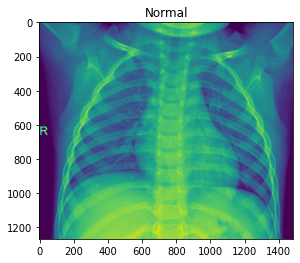

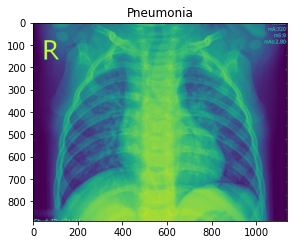

In [ ]:
print(len(os.listdir(trainN)))
rand_norm = np.random.randint(0,len(os.listdir(trainN)))
norm_pic = os.listdir(trainN)[rand_norm]
print('normal picture title: ', norm_pic)

norm_pic_add = trainN+norm_pic

rand_p = np.random.randint(0, len(os.listdir(trainP)))

pneu_pic = os.listdir(trainP)[rand_p]
pneu_pic_add = trainP + pneu_pic
print('pneumonia picture title: ', pneu_pic)

# Load images
norm_load = Image.open(norm_pic_add)
pneu_load = Image.open(pneu_pic_add)

f = plt.figure(figsize = (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load)
a1.set_title('Normal')

f2 = plt.figure(figsize =(10,6))
a2 = f2.add_subplot(1,2,1)
img_plot2 = plt.imshow(pneu_load)
a2.set_title('Pneumonia')

In [ ]:
sns.distplot(norm_load.ravel(),
             label=f"Pixel Mean {np.mean(norm_load):.3f} & Standard Deviation {np.std(norm_load):.3f}", 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [ ]:
!pip install mpldatacursor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import mplcursors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21069 sha256=d04496d7f5945511f5a1fc37c21124e4f43b001f5aa88e236217aec1631e788e
  Stored in directory: /root/.cache/pip/wheels/b1/98/ff/4885c231adf3d185efdc38cf8aa2527f1b255ca714a43cb125
Successfully built mplcursors


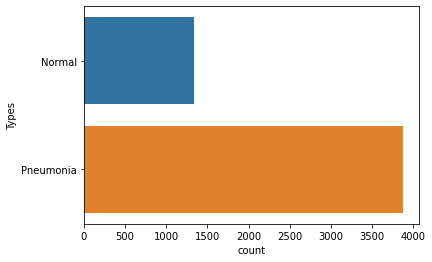

In [ ]:
n_count = len(os.listdir(trainN))
p_count = len(os.listdir(trainP))

df = pd.DataFrame({'Types': ['Normal', 'Pneumonia'], 'count':[n_count, p_count]})
sns.barplot(x=df['count'], y=df['Types'], orient='h')
plt.show()

<h1>Train Model</h1>

In [ ]:


batch_size = 32
img_height = 128
img_width = 64


# 2 convolutions with max pool after each convolution
# use 2 fc to make feature map, 2nd fc has 1 unit becasue it needs to predict if data has pneumonia or not

# relu = rectified linear, values would range from 0 to infinity. any negative values would be treated as 0
# sigmoid = values would range from 0 to 1


# tf.keras.utils.image_dataset_from_directory utility will take from a directory of images on disk to a tf.data.Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# used to prevent overfitting
val_ds = tf.keras.utils.image_dataset_from_directory(
  val,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# used to evaluate accuracy of model
test_ds = tf.keras.utils.image_dataset_from_directory(
  test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)


model = Sequential([
  Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)),
  MaxPooling2D(pool_size = (2, 2)),
  Conv2D(32, (3, 3), activation="relu"),
  MaxPooling2D(pool_size = (2, 2)),
  Flatten(),
  Dense(activation = 'relu', units = 128),
  Dense(num_classes)

])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


model.summary()




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1>Evaluate Model</h1>

In [ ]:
# train model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, acc = model.evaluate(test_ds)